In [1]:
import pandas as pd
import os
import warnings
from scipy.stats import ttest_ind
from lifelines import CoxPHFitter
from scipy import stats
from sklearn import preprocessing
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

warnings.filterwarnings('ignore')

### General Notes
The code assumes that in the working directory we have the following structure:
- maf folder with the download content of tcga masked maf files 
- counts folder with the download content of tcga star counts
- sample sheets for both counts and maf dowload data
- clinical info file (TCGA)
- clinical info file (cbioportal)

## Cbioportal
### Survival info

In [2]:
surv_df = pd.read_csv('combined_study_clinical_data(3).tsv',sep = '\t')
survival = surv_df[['Patient ID','Months of disease-specific survival','Disease Free (Months)','Disease Free Status','Year Cancer Initial Diagnosis']]
survival['DFS_binary'] = survival['Disease Free Status'].str[0]
survival['DFS_months'] = survival[['Disease Free (Months)', 'Months of disease-specific survival']].mean(axis=1, skipna=True)

## Endpoint
#### Binary


In [3]:
#print(survival['DFS_binary'].corr(survival['Year Cancer Initial Diagnosis']))
binary_DFS = dict(zip(survival['Patient ID'].tolist(), survival['DFS_binary'].tolist()))
surv_df = surv_df[surv_df['Patient ID'].isin(list(binary_DFS.keys()))]
surv_df = surv_df[['Patient ID','Age','BMI','FIGO Stage','Histologic FIGO Grade','p53','POLE Subtype','TMB (nonsynonymous)','POLE ultra-mutated','Pregnancies full term count']]

#### Quantitative (months)
Months info on disease free survival is quite correlated with the year of diagnosis, a weighted approach may be needed (400 samples).


In [4]:
print(survival['DFS_months'].corr(survival['Year Cancer Initial Diagnosis']))
survival = survival[survival['Year Cancer Initial Diagnosis'].notna()]
survival = survival[survival['DFS_months'].notna()]
months_DFS = dict(zip(survival['Patient ID'].tolist(), survival['DFS_months'].tolist()))
survival = survival[['Patient ID', 'DFS_binary','DFS_months']]

-0.6867952512342571


#### Merging Survival Info

In [5]:
survival = survival.merge(surv_df,right_on = 'Patient ID',left_on = 'Patient ID')
survival = survival[['Patient ID','DFS_binary','DFS_months','Age','Pregnancies full term count']]

#### Full term pregnancies subset

In [6]:
preg = survival[survival['Pregnancies full term count'].notna()]

#### Final DFS Info

In [7]:
survival = survival.drop_duplicates('Patient ID').drop('Pregnancies full term count',axis=1)

# Expression Level Matrix
- FPKM normalization used

### Levels Extraction and Merge

In [8]:
campioni=pd.read_csv('gdc_sample_sheet.2022-04-28.tsv',sep='\t') # dataframe con nome campione + nome tcga (due colonne da fare a mano seguento i file txt nella cartella)

In [9]:
dfs={}
pattern='gene_counts.tsv' #definire pattern nel nome della matrice di espressione normalizzata
folders = os.listdir(os.getcwd()+'/files')
folders.remove('.DS_Store')

for subdir in folders:
    files = os.listdir(os.getcwd()+'/files/'+subdir)
    filelist = [f for f in files if f.endswith(f'{pattern}')]
    file = os.getcwd()+'/files/'+subdir+'/'+filelist[0]
    df_tmp=pd.read_csv(file,sep='\t',skiprows=1)
    df_tmp = df_tmp[df_tmp['gene_name'].notna()].sort_values(by='gene_name')
    dfs[filelist[0]]=df_tmp['fpkm_unstranded'].tolist()
    genes = df_tmp['gene_name']

### Renaming Samples and Tumor/Normal Splitting

In [10]:
matrix = pd.DataFrame.from_dict(dfs)
matrix.index = genes

In [11]:
d = dict(zip(campioni['File Name'].tolist(),campioni['Sample ID'].tolist()))
matrix = matrix.rename(columns = d)
l = matrix.columns.to_list()
tumor = [e for e in l if e.endswith('01A')] + [e for e in l if e.endswith('01B')]
normal_blood = [e for e in l if e.endswith('11A')] + [e for e in l if e.endswith('11B')]

### Filtering and export

In [12]:
matrix['sum'] = matrix.sum(axis=1)
matrix = matrix[matrix['sum'] != 0 ]
matrix = matrix.drop('sum',axis=1)
tum_matrix = matrix[tumor]
norm_matrix = matrix[normal_blood]

In [13]:
tum_matrix.columns = [e[:-4] for e in tum_matrix.columns]
tum_matrix.to_csv('endom_tum_fpkm.tsv',sep='\t')

In [14]:
norm_matrix.columns = [e[:-4] for e in norm_matrix.columns]
norm_matrix.to_csv('blood_fpkm.tsv',sep='\t')

### Feature Extraction 
Overexpression to be substitute with deseq 2 results


#### L1CAM

In [15]:
l1cam_high = tum_matrix.loc[:,tum_matrix.loc['L1CAM'] > tum_matrix.loc['L1CAM'].median()].columns.tolist()

#### TP53

In [16]:
tp53_high = tum_matrix.loc[:,tum_matrix.loc['TP53'] > tum_matrix.loc['TP53'].median()].columns.tolist()

# Mutation Data

In [17]:
campioni_maf=pd.read_csv('gdc_sample_sheet.2022-05-03.tsv',sep='\t') # dataframe con nome campione + nome tcga (due colonne da fare a mano seguento i file txt nella cartella)

#### Mutation extraction and merge

In [18]:
multimaf=pd.DataFrame(columns=['Hugo_Symbol','Chromosome','Start_Position','End_Position','Variant_Classification','dbSNP_RS','t_depth','t_alt_count','VAF','CLIN_SIG','Tumor_Sample_Barcode','case_id'])
pattern='masked.maf.gz' #definire pattern nel nome della matrice di espressione normalizzata
folders = os.listdir(os.getcwd()+'/maf')
folders.remove('.DS_Store')
folders.remove('MANIFEST.txt')

for subdir in folders:
    files = os.listdir(os.getcwd()+'/maf/'+subdir)
    filelist = [f for f in files if f.endswith(f'{pattern}')]
    file = os.getcwd()+'/maf/'+subdir+'/'+filelist[0]
    df_tmp=pd.read_csv(file,sep='\t',skiprows=7)
    df_tmp = df_tmp[['Hugo_Symbol','Chromosome','Start_Position','End_Position','Variant_Classification','dbSNP_RS','t_depth','t_alt_count','CLIN_SIG','Exon_Number','Tumor_Sample_Barcode','case_id']]
    df_tmp['VAF'] = df_tmp['t_alt_count']/df_tmp['t_depth'] 
    #df_tmp = df_tmp[~(df_tmp['Hugo_Symbol'] == 'POLE') & (df_tmp['Exon_Number'].isna())]
    df_tmp['Exon_Number'] = df_tmp['Exon_Number'].map(lambda x: str(x).split('/')[0])
    multimaf = multimaf.append(df_tmp)

#### Simplifying Pathogenicity Annotation (discrete to bynary)

In [19]:
clinvar_bin = multimaf[multimaf['CLIN_SIG'].str.contains('pathogen',na=False)]
clinvar_bin['Pathogenicity'] = 1
multimaf = multimaf.merge(clinvar_bin,how='outer')

#### Filtering by VAF > 5%

In [20]:
multimaf = multimaf[multimaf['VAF']>0.05]

In [21]:
multimaf.to_csv('multimaf.tsv',sep='\t')

### Feature Extraction

#### TMB

In [22]:
exome_bases = 30*(10**6)
tmb_samples = {}
ids = set(multimaf['Tumor_Sample_Barcode'].tolist())
for sample in ids:
    n_mut=len(multimaf[multimaf['Tumor_Sample_Barcode']==sample])
    tmb = (n_mut * 10**6)/exome_bases
    sample_short = sample.split('-01A-')[0]
    tmb_samples[sample_short] = tmb

In [23]:
tmb = pd.DataFrame.from_dict([tmb_samples.keys(),tmb_samples.values()]).T

In [24]:
tmb.columns = ['Sample ID','TMB']
tmb = tmb.drop_duplicates('Sample ID')

#### POLE, TP53, CTNNB1 mutant

In [25]:
pole_case_ids = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Exon_Number'].isin(['9','10','11','12','13','14'])][multimaf['Hugo_Symbol'].isin(['POLE'])]['case_id'].tolist()
tp53_case_ids = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['TP53'])]['case_id'].tolist()
ctnnb1_case_ids = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['CTNNB1'])]['case_id'].tolist()

#### MSI

In [26]:
ACVR2A = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['ACVR2A'])]['case_id'].tolist()
BTBD7 = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['BTBD7'])]['case_id'].tolist()
DIDO1 = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['DIDO1'])]['case_id'].tolist()
MRE11 = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['MRE11'])]['case_id'].tolist()
RYR3 = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['RYR3'])]['case_id'].tolist()
SEC31A = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['SEC31A'])]['case_id'].tolist()
SULF2 = multimaf[multimaf['Variant_Classification']=='Missense_Mutation'][multimaf['Hugo_Symbol'].isin(['SULF2'])]['case_id'].tolist()

In [27]:
msi_case_ids = set(ACVR2A).union(set(BTBD7)).union(set(DIDO1)).union(set(MRE11)).union(set(RYR3)).union(set(SEC31A)).union(set(SULF2))

# Molecular + Clinical Data

In [290]:
clinical = pd.read_csv('clinical.tsv',sep='\t')
clinical = clinical[clinical['primary_diagnosis'] == 'Endometrioid adenocarcinoma, NOS']
clinical = clinical.merge(tmb, right_on = 'Sample ID',left_on = 'case_submitter_id')

### TMB

In [291]:
clinical = clinical.drop('TMB',axis=1)
clinical = clinical.merge(tmb,how='outer', left_on = 'Sample ID', right_on = 'Sample ID')
clinical['TMB_high'] = clinical['TMB'] > clinical['TMB'].median()
#clical = clinical.drop_duplicates('Sample ID')

### POLE, TP53, CTNNB1 and L1CAM
Feature Generation

In [292]:
TP53, POLE, CTNNB1, L1CAM, MSI = [],[],[],[],[]
for sample_id, case_id, tmbH, figo in zip(clinical['Sample ID'].tolist(),clinical['case_id'].tolist(),clinical['TMB_high'].tolist(),clinical['figo_stage'].tolist()):
    
    if figo in ['Stage II','Stage IIA','Stage IIB','Stage IIC''Stage I','Stage IA','Stage IB','Stage IC']:
        lowgrade = True
    else:
        lowgrade = False
    
    if sample_id in tp53_high and tmbH == True:
        TP53.append(1)
    elif case_id in tp53_case_ids and tmbH == True:
        TP53.append(1)
    else: 
        TP53.append(0)
    
    if case_id in pole_case_ids and tmbH == True:
        POLE.append(1)
    else:
        POLE.append(0)
        
    if case_id in ctnnb1_case_ids and lowgrade == True:
        CTNNB1.append(1)
    else:
        CTNNB1.append(0)
    
    if case_id not in tp53_case_ids and case_id in l1cam_high:
        L1CAM.append(1)
    else:
        L1CAM.append(0)  
    
    if case_id in msi_case_ids:
        MSI.append(1)
    else:
        MSI.append(0)

In [293]:
clinical['TP53'] = TP53
clinical['POLE'] = POLE
clinical['CTNNB1'] = CTNNB1
clinical['L1CAM'] = L1CAM
clinical['MSI'] = MSI

In [294]:
clinical = clinical[['Sample ID','gender','race','age_at_diagnosis','figo_stage','primary_diagnosis','prior_malignancy','treatment_or_therapy','prior_treatment','year_of_diagnosis','treatment_type','TP53','POLE','CTNNB1','L1CAM','MSI','TMB_high','TMB']]

### Cybersort
- Signature matrix file: LM22.update-gene-symbols.txt
- Mixture file: endom_tum_fpkm.tsv
- Batch correction: enabled
- Batch correction mode: B-mode
- Source GEP file used for batch correction: LM22.update-gene-symbols.txt
- Disable quantile normalization: true
- Run mode (relative or absolute): relative
- Permutations: 50

In [295]:
cyber = pd.read_csv('CIBERSORTx_Job4_Results.csv')
cyber = cyber[['Mixture', 'B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']]

In [296]:
clinical = clinical.merge(cyber,left_on='Sample ID',right_on='Mixture',how='inner')

### Signatures

In [297]:
normals = pd.read_csv('output/blood_fpkm.tsv',sep='\t',index_col=0)
tumor = pd.read_csv('output/endom_tum_fpkm.tsv',sep='\t',index_col=0)

In [298]:
IFNg6 = ['IDO1','CXCL10','CXCL9','HLA-DRA','IFNG','STAT1']
IFNgei18 = ['CD3D','IL2RG','NKG7','CIITA','HLA-E','CD3E','CXCR6','CCL5','LAG3','TAGAP','GZMK','CD2', 'IDO1','CXCL10','HLA-DRA','STAT1','CXCL13','GZMB']
effTcell = ['GZMA','GZMB','PRF1','IFNG','EOMES', 'CD8A']
IFNg_effTcell = ['CD8A', 'GZMA', 'GZMB', 'IFNG', 'EOMES', 'CXCL9', 'CXCL10', 'TBX21']
chemok = ['CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL8', 'CCL18', 'CCL19', 'CCL21', 'CXCL9', 'CXCL10', 'CXCL11', 'CXCL13']
TGFb = ['ACTA2', 'ACTG2', 'ADAM12', 'ADAM19', 'CNN1', 'COL4A1', 'CCN2', 'CTPS1', 'RFLNB', 'FSTL3', 'HSPB1', 'IGFBP3', 'PXDC1', 'SEMA7A', 'SH3PXD2A', 'TAGLN', 'TGFBI', 'TNS1', 'TPM1']
bCatenin = ['EFNB3','APC2','TCF7','MYC','TCF12','VEGFA']
MPS = ['AKR1C3', 'BMP1', 'CRTAC1', 'ECEL1', 'ERC2', 'FAM110C', 'FUT9', 'GABRA2', 'GAP43', 'GREM1', 'HECW1', 'KLHL1', 'KRT12', 'LHFPL4', 'NEFL', 'NEFM', 'NETO1', 'NKX2-2', 'NSG2', 'OCIAD2', 'OTOP1', 'PDE3B', 'PTPRN2', 'PTPRT', 'SIGLEC15', 'SLC13A5', 'SLC9A2', 'SLITRK6', 'SNAP91', 'STON2', 'TAC1', 'VAT1L', 'WNT5A', 'ALX1', 'BRD7', 'DTD1', 'GRSF1', 'HCN1', 'LTA4H', 'OXCT1', 'PATJ', 'PLXNC1', 'SSBP4', 'TELO2', 'TMEM177']
bruno_sig = ['NLRP3','CXCL12','CCL2','CCL20','IL1B','CXCL9','CXCL10','CCL5','IL10','IL15','IL18','PDCD1','CCL3','CCL4','EBI3']
signature_names = ['IFNg6','IFNgei18','effTcell','IFNg_effTcell','chemok','TGFb','bCatenin','MPS','bruno_sig']

In [299]:
i= 0
for signature in [IFNg6,IFNgei18,effTcell,IFNg_effTcell,chemok,TGFb,bCatenin,MPS,bruno_sig]:
    signature_name = signature_names[i]
    subset = tumor.loc[signature]+1
    gmean = stats.gmean(subset.iloc[:,:],axis=0).tolist()
    subset.loc['gmean'] = gmean
    l = []
    for sample in clinical['Sample ID'].tolist():
        l.append(subset[sample]['gmean'])
    clinical[signature_name] = l
    i+=1

### Survival Info

In [300]:
final = survival.merge(clinical,left_on='Patient ID',right_on='Sample ID').drop(['age_at_diagnosis','gender','primary_diagnosis','Mixture','Sample ID'],axis=1)
final = final[final['Patient ID'] != 'TCGA-B5-A1MR']

### Treatment

In [301]:
pha = final[(final['treatment_or_therapy'] == 'yes') & (final['treatment_type'] == 'Pharmaceutical Therapy, NOS')]['Patient ID'].tolist()

In [302]:
rad = final[(final['treatment_or_therapy'] == 'yes') & (final['treatment_type'] == 'Radiation Therapy, NOS')]['Patient ID'].tolist()

In [303]:
test = pd.DataFrame(final[(final['treatment_or_therapy'] == 'yes')]['Patient ID'].value_counts())
both = test[test['Patient ID']>=2].index.tolist()

In [304]:
test = pd.DataFrame(final[(final['treatment_or_therapy'] == 'no')]['Patient ID'].value_counts())
neither = test[test['Patient ID']>=2].index.tolist()

In [305]:
pha = list(set(pha).difference(set(both)))
rad = list(set(rad).difference(set(both)))

In [306]:
t = ['both']*len(both) + ['neither']*len(neither) + ['rad']*len(rad) + ['pha']*len(pha)
p = both + neither + rad + pha
treat_df = pd.DataFrame([p,t],index=['Patient ID','treatment']).T

In [307]:
final = final.drop(['treatment_or_therapy','treatment_type'],axis=1)
final = final.drop_duplicates()

In [308]:
final = final.merge(treat_df, on='Patient ID')

## Export

In [311]:
final = final.set_index('Patient ID')
final.to_csv('final.csv')

KeyError: "None of ['Patient ID'] are in the columns"

# Features Refinement

In [312]:
cols_to_norm = ['Age',
             'year_of_diagnosis',
             'B cells naive',
             'B cells memory',
             'Plasma cells',
             'T cells CD8',
             'T cells CD4 naive',
             'T cells CD4 memory resting',
             'T cells CD4 memory activated',
             'T cells follicular helper',
             'T cells regulatory (Tregs)',
             'T cells gamma delta',
             'NK cells resting',
             'NK cells activated',
             'Monocytes',
             'Macrophages M0',
             'Macrophages M1',
             'Macrophages M2',
             'Dendritic cells resting',
             'Dendritic cells activated',
             'Mast cells resting',
             'Mast cells activated',
             'Eosinophils',
             'Neutrophils',
             'IFNg6',
             'IFNgei18',
             'effTcell',
             'IFNg_effTcell',
             'chemok',
             'TGFb',
             'bCatenin',
             'MPS',
             'bruno_sig',
             'TMB']

cols_to_convert = ['race',
                  'figo_stage',
                  'prior_malignancy',
                  'prior_treatment',
                  'treatment',
                  'TMB_high']

In [313]:
for col in cols_to_norm:
    x = np.array(final[col])
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    final[col] = x_scaled

In [314]:
mapping = dict()
for col in cols_to_convert:
    mapping[col] = pd.factorize(final[col],sort=True)[1]
    final[col] = pd.factorize(final[col],sort=True)[0] 

In [315]:
mapping

{'race': Index(['american indian or alaska native', 'asian',
        'black or african american',
        'native hawaiian or other pacific islander', 'not reported', 'white'],
       dtype='object'),
 'figo_stage': Index(['Stage I', 'Stage IA', 'Stage IB', 'Stage IC', 'Stage II', 'Stage IIA',
        'Stage IIB', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC',
        'Stage IIIC1', 'Stage IIIC2', 'Stage IV', 'Stage IVA', 'Stage IVB'],
       dtype='object'),
 'prior_malignancy': Index(['no', 'yes'], dtype='object'),
 'prior_treatment': Index(['No'], dtype='object'),
 'treatment': Index(['both', 'neither', 'pha', 'rad'], dtype='object'),
 'TMB_high': Index([False, True], dtype='object')}

In [316]:
final = final[final['DFS_months'] > 0]
final = final.reset_index()
final = final.dropna()
final = final.drop_duplicates(subset='Patient ID')

In [317]:
final.to_csv('final_normalized.csv')

# Data Exploration

<AxesSubplot:>

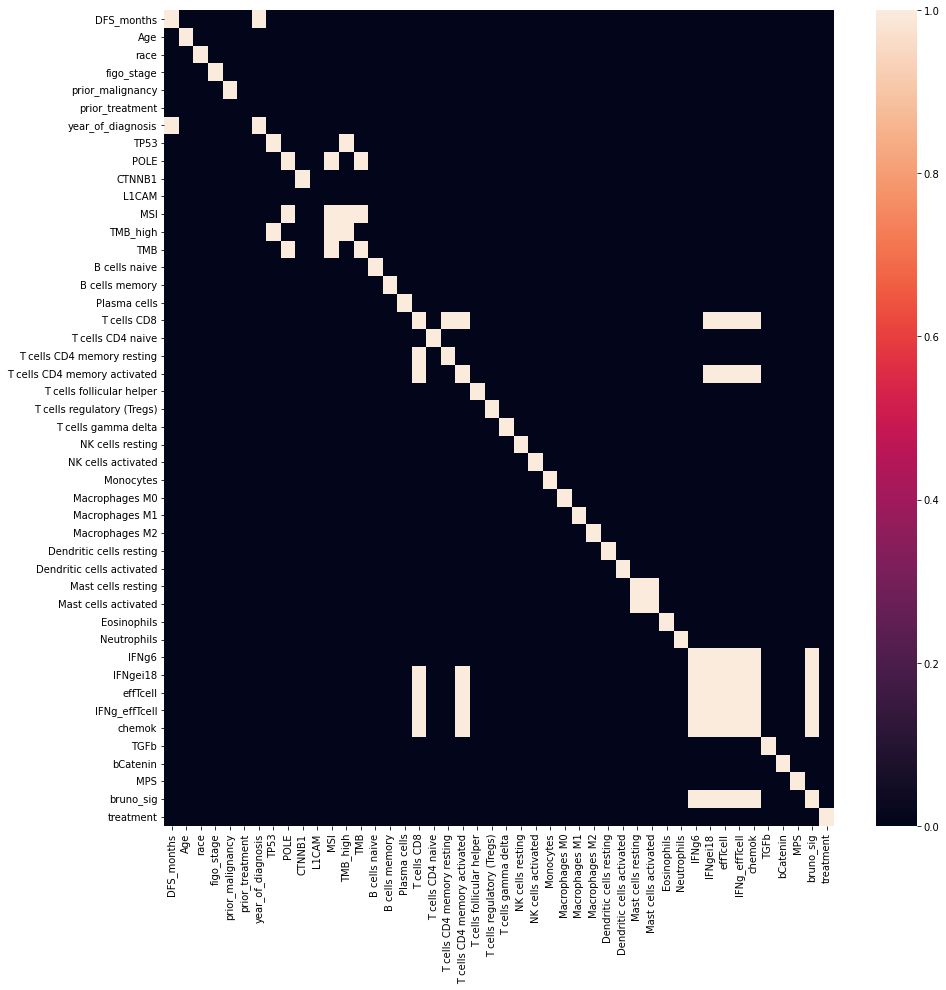

In [261]:
plt.subplots(figsize=(15, 15))
sns.heatmap(abs(final.corr())>0.5)

<AxesSubplot:>

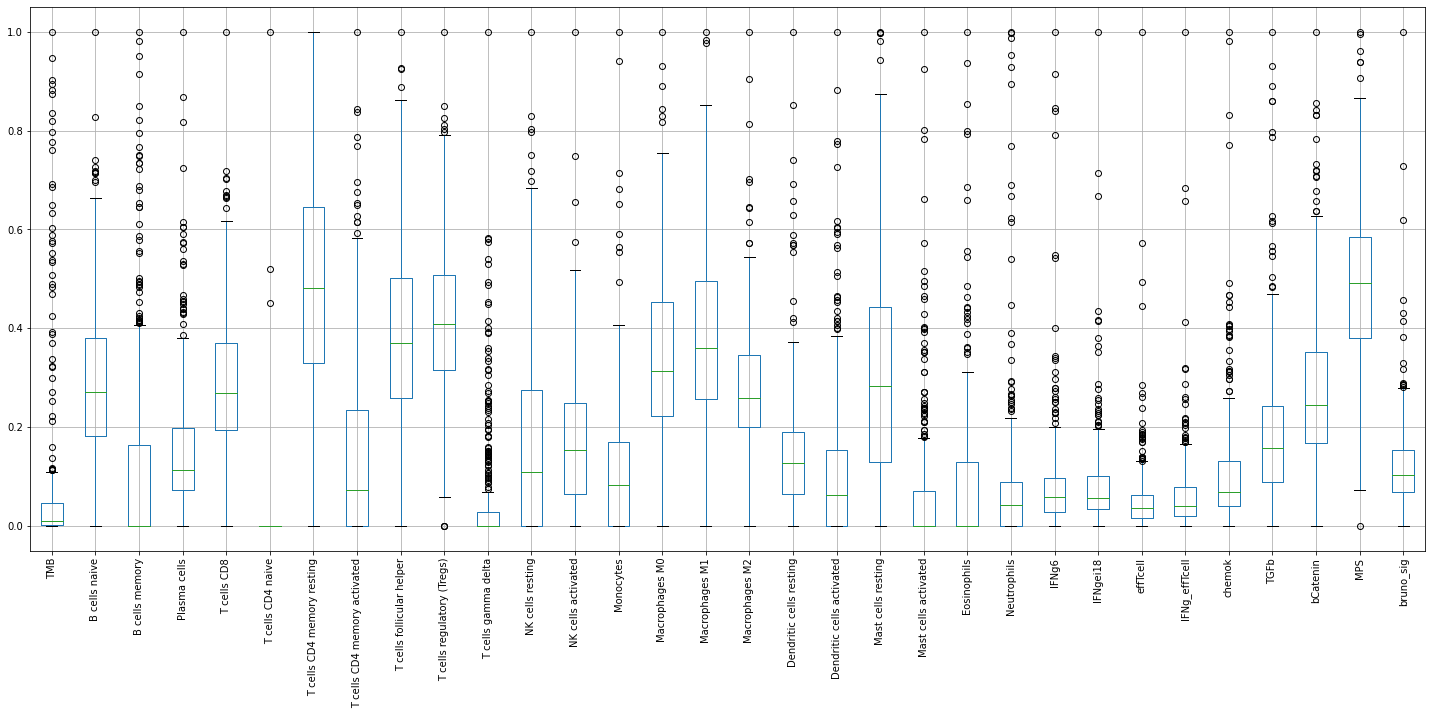

In [200]:
final[['TMB', 'B cells naive', 'B cells memory', 'Plasma cells', 'T cells CD8',
       'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils', 'IFNg6',
       'IFNgei18', 'effTcell', 'IFNg_effTcell', 'chemok', 'TGFb', 'bCatenin',
       'MPS', 'bruno_sig']].boxplot(figsize=(25,10),rot=90)

In [201]:
categorical = ['race', 'figo_stage','prior_malignancy', 'prior_treatment','treatment_type', 
               'TP53', 'POLE', 'CTNNB1', 'L1CAM', 'MSI', 'TMB_high']
for e in categorical:
    print(final[[e]].value_counts())

race
5       243
2        55
1        17
4        13
3         6
0         2
dtype: int64
figo_stage
1             125
2              97
8              23
4              22
3              15
10             10
11             10
15              8
6               7
12              6
0               3
5               3
9               3
7               2
13              1
14              1
dtype: int64
prior_malignancy
0                   309
1                    27
dtype: int64
prior_treatment
No                 336
dtype: int64
treatment_type             
Pharmaceutical Therapy, NOS    168
Radiation Therapy, NOS         168
dtype: int64
TP53
0       219
1       117
dtype: int64
POLE
0       290
1        46
dtype: int64
CTNNB1
0         249
1          87
dtype: int64
L1CAM
0        336
dtype: int64
MSI
0      240
1       96
dtype: int64
TMB_high
1           176
0           160
dtype: int64
